In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats, integrate
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats, integrate
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

C:\Python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Importing the train and test datasets
train = pd.read_csv("data/Train.csv")

In [3]:
# Convert to datatime
train_original=train.copy() 

import datetime 
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M',infer_datetime_format=True) 
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d %m %Y %H:%M',  infer_datetime_format=True)


In [4]:
for i in (train, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [5]:
train['day of week']=train['Datetime'].dt.dayofweek 
temp = train['Datetime']

In [6]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2

In [7]:

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Converting to daily mean 
train = train.resample('H').mean()

C:\Python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [8]:
Train=train.loc['2012-08-25 00:00:00':'2014-06-24 23:00:00'] 
valid=train.loc['2014-06-25 00:00:00':'2014-09-25 23:00:00']

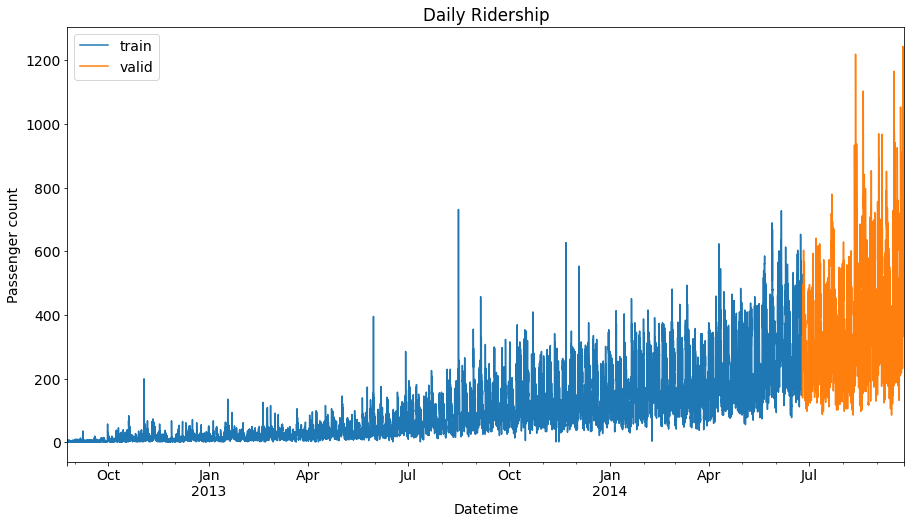

In [9]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

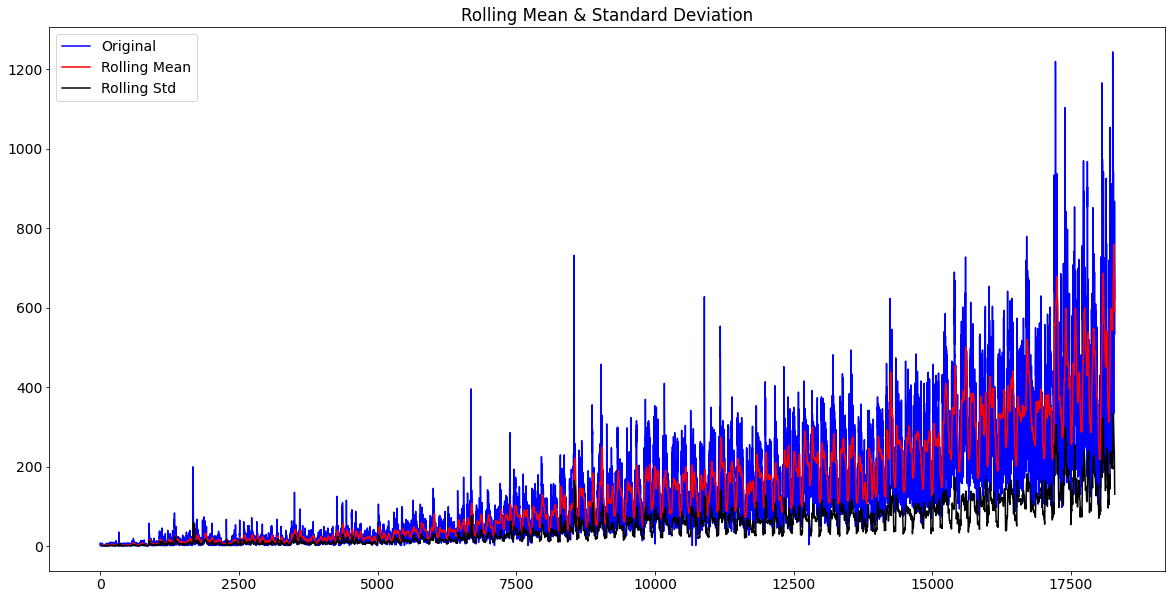

Results of Dickey-Fuller Test:
Test Statistic                   -4.46
p-value                           0.00
#Lags Used                       45.00
Number of Observations Used   18242.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


In [10]:
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10

test_stationarity(train_original['Count'])

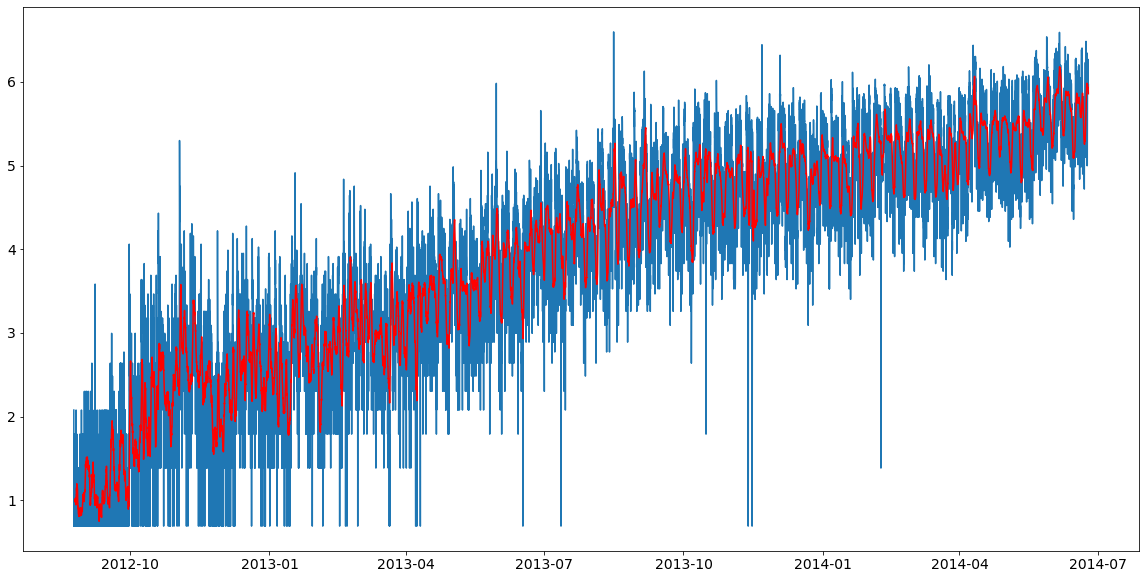

In [11]:
# Removing trend

Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()


In [12]:
train_log_diff = Train_log - Train_log.shift(1) 

In [13]:
import statsmodels.api as sm
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,24)).fit() 


C:\Python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


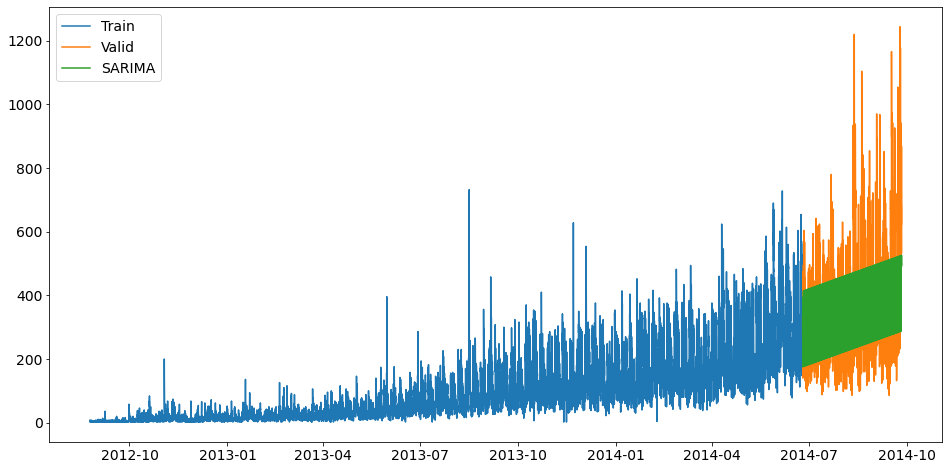

In [14]:
y_hat_avg['SARIMA'] = fit1.predict(valid.index.min(), valid.index.max(), dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

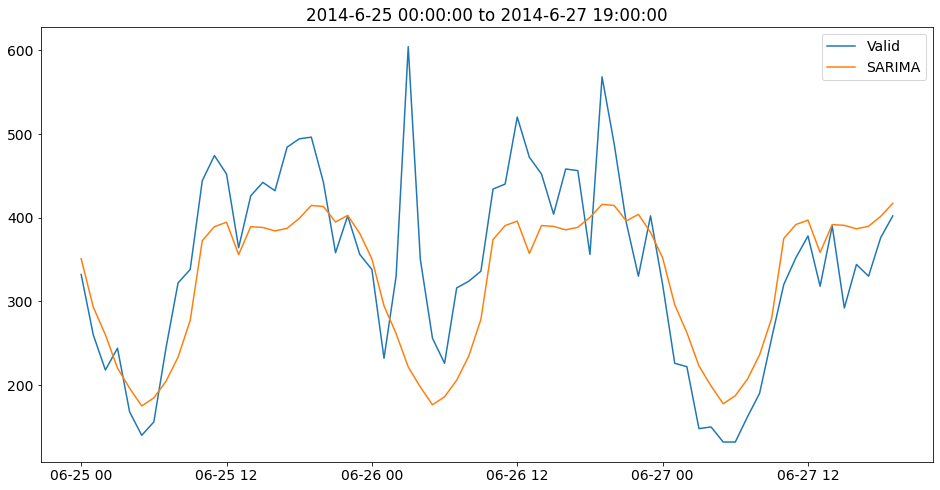

In [15]:
y_hat_avg_2 = valid.copy() 
y_hat_avg_2['SARIMA'] = fit1.predict(start="2014-6-25 00:00:00", end="2014-6-27 19:00:00", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot(valid.loc["2014-6-25 00:00:00":"2014-6-27 19:00:00"]['Count'], label='Valid') 
plt.plot(y_hat_avg_2['SARIMA'], label='SARIMA') 
plt.title("2014-6-25 00:00:00 to 2014-6-27 19:00:00")
plt.legend(loc='best') 
plt.show()

In [16]:
from math import sqrt 
from sklearn.metrics import mean_squared_error 

rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA)) 

print()
print("RMS Value: ")
print(rms)



RMS Value: 
137.13990364354268


In [17]:
import pickle as pkl

pkl.dump(fit1, open("model.pkl", "wb"))